In [ ]:
import ee
import math
import geemap
import pprint
import datetime
import pandas as pd
from tabulate import tabulate

ee.Authenticate
ee.Initialize(project='toribiodiego-ece471')

# Homework 2
- ECE471: Fundamentals of Remote Sensing and Earth Observation
- Spring 2025
- Instructor: Krishna Karra
- Contact: krishna.karra@cooper.edu (Teams chat is quickest)
- Assigned: Wednesday, February 26, 2025
- Due: Tuesday, March 18, 2025 (by midnight EST)

## Problem Motivation

The United States Department of Agriculture (USDA), in conjunction with the United States Geological Survey (USGS), produces the Cropland Data Layer (CDL), an annual landcover map of crop types across the Continental United States at 30-meter resolution. This map, which incorporates Landsat and Sentinel imagery from across the year, represents some of the highest quality, rigorously validated land cover classification that can be found anywhere.

A year's annual map is usually released a few months into the next year (e.g. the 2020 CDL is released towards the end of the first quarter of 2021). As a geospatial consultant, your task is to investigate whether certain crop types could be predicted *in-season* (e.g. without using a full year's worth of imagery).

The CDL is used within government and industry for crop health monitoring, crop area estimation, agricultural policy development, environmental monitoring, yield forecasting and more. In-season prediction of crop types would be vastly useful for all of these applications.

For this pilot study, the focus will be on Iowa and Illinois.

## Problem Overview

The overall workflow will be:

1. Analyze cropland data to identify the 5 most prevalent crops grown in Iowa and Illinois.
2. Explore and visualize the seasonal patterns of those 5 crops using vegetation index time series analysis.
3. Develop a crop identification model that takes satellite imagery as input and predicts crop type at the pixel level.
4. Assess model performance using validation data and metrics.
5. Apply the model to full counties to produce crop type maps and compare against ground truth data.

The core data sources will be:

1. Cropland Data Layer (CDL) for crop type ground truth labels
2. Landsat satellite imagery for model inputs
3. Google Earth Engine (GEE) platform for analysis and modeling

This assignment will give you real, concrete experience with:

- Working with large-scale geospatial data
- Time series analysis of vegetation indices
- Developing and validating a remote sensing model
- Creating meaningful data visualizations and maps

Your modeling approach and additional data sources are flexible. The key deliverables are: ranked crop list, crop seasonal analysis, trained crop identification model, model evaluations, and final county-level crop maps.

## Task 1: Identify Most Prevalent Crops

###*Goal: Plan to have made significant progress on Task 1 (or completed it) by March 5.*

The goal of this task is to create a ranked list of the most commonly grown crops across Iowa and Illinois based on acreage data from the 2019 Cropland Data Layer (CDL).

Specifically, you should:

1. Load the 2019 CDL raster data for the 2 states from Google Earth Engine.
2. Write a script to calculate the total acreage of each unique crop type in the CDL legend across the 2 states.
3. Rank the crops based on total acreage from most to least.
4. Output the list as a CSV file with two columns: Crop Name and Total Acres. Include the top 20 crops. Include the top 20 crops.
5. From this list, select the top 5 most prevalent crops. These will be the focus for the rest of the analysis.

Things to keep in mind:

1. Analysis must be done programmatically using GEE.
2. Output must be a clean CSV file with the columns specified.
3. Make sure to handle any data filtering or preprocessing steps like reprojections.
4. Document your methodology and thought process

### 1.1 - helper functions

In [ ]:
def compute_crop_acreage_table(region, crop_legend, csv_filename=None):
    """
    Computes the total acreage by crop code for the given region,
    maps crop codes to crop names, ranks them by acreage,
    rounds the acreage values to two decimal places,
    and returns a formatted table string.

    Additionally, if a csv_filename is provided, saves a CSV file containing
    the top 20 crops with two columns: Crop Name and Total Acres.

    Parameters:
      region: An ee.Geometry defining the area of interest.
      crop_legend: A dictionary mapping crop codes (int) to crop names (str).
      csv_filename: (Optional) Filename (str) to save the CSV output.

    Returns:
      A formatted string containing the table with columns:
      Rank, Crop Code, Crop Name, Total Acres.
    """
    # Load the 2019 CDL image.
    cdl_2019 = ee.Image('USDA/NASS/CDL/2019')

    # Create a reducer that sums the area (weighted input)
    # and groups by the crop code (grouping input, which is in the second band, index=1).
    reducer = ee.Reducer.sum().group(
        groupField=1,  # crop code is in the second band (index 1)
        groupName='crop_code'
    )

    # Each pixel is 30 m x 30 m (900 m^2).
    # Create an area image (in acres).
    area_image = ee.Image.pixelArea().multiply(0.000247105)

    # Add the 'cropland' band from the CDL image as the second band.
    combined_image = area_image.addBands(cdl_2019.select('cropland'))

    # Reduce the image over the provided region.
    stats = combined_image.reduceRegion(
        reducer=reducer,
        geometry=region,
        scale=30,
        maxPixels=1e13
    )

    # Retrieve the computed list as a Python object.
    groups = stats.get('groups').getInfo()

    # Prepare table data, adding crop names and rounding acreage.
    table_data = []
    for entry in groups:
        crop_code = entry['crop_code']
        acreage = round(entry['sum'], 2)  # Round to two decimal places
        crop_name = crop_legend.get(crop_code, "Unknown")
        table_data.append({
            "Crop Code": crop_code,
            "Crop Name": crop_name,
            "Total Acres": acreage
        })

    # Sort table data by Total Acres in descending order.
    table_data_sorted = sorted(table_data, key=lambda x: x["Total Acres"], reverse=True)

    # Add the Rank column.
    for idx, row in enumerate(table_data_sorted, start=1):
        row["Rank"] = idx

    # Rearrange columns so that Rank comes first.
    table_data_ranked = []
    for row in table_data_sorted:
        table_data_ranked.append({
            "Rank": row["Rank"],
            "Crop Code": row["Crop Code"],
            "Crop Name": row["Crop Name"],
            "Total Acres": row["Total Acres"]
        })

    # Create a formatted table using tabulate.
    table_str = tabulate(table_data_ranked, headers="keys", tablefmt="grid")

    # If a CSV filename is provided, save the top 20 crops (only Crop Name and Total Acres).
    if csv_filename:
        df = pd.DataFrame(table_data_ranked)
        # Sort by Total Acres descending and select top 20.
        df_top20 = df.sort_values(by="Total Acres", ascending=False).head(20)
        # Select only the columns "Crop Name" and "Total Acres"
        df_top20 = df_top20[["Crop Name", "Total Acres"]]
        df_top20.to_csv(csv_filename, index=False)
        print("CSV file saved as:", csv_filename)

    return table_str


# helper function to retrieve the ee.Geometry of a county given its name
def get_county_geometry(county_name):
    # Filter the FeatureCollection to the county with the given name.
    county_feature = iowa_counties.filter(ee.Filter.eq('NAME', county_name)).first()
    return county_feature.geometry()

### 1.2 - Regions, Regions, Regions

In [ ]:
# The USDA Cropland Data Layer for 2019 can be accessed via:
cdl_2019 = ee.Image('USDA/NASS/CDL/2019')

# Retrieve the properties from the image.
crop_class_names = cdl_2019.get('cropland_class_names').getInfo()
crop_class_values = cdl_2019.get('cropland_class_values').getInfo()

# Check if crop_class_names is a string; if so, split it into a list.
crop_class_names = crop_class_names.split(',')

# Similarly, if crop_class_values is a string, split it and convert to integers.
crop_class_values = [int(val) for val in crop_class_values.split(',')]

# Create a dictionary mapping crop codes to crop names.
crop_legend = dict(zip(crop_class_values, crop_class_names))

print("Crop Legend:")
print(crop_legend)

Crop Legend:
{0: 'Background', 1: 'Corn', 2: 'Cotton', 3: 'Rice', 4: 'Sorghum', 5: 'Soybeans', 6: 'Sunflower', 10: 'Peanuts', 11: 'Tobacco', 12: 'Sweet Corn', 13: 'Pop or Orn Corn', 14: 'Mint', 21: 'Barley', 22: 'Durum Wheat', 23: 'Spring Wheat', 24: 'Winter Wheat', 25: 'Other Small Grains', 26: 'Dbl Crop WinWht/Soybeans', 27: 'Rye', 28: 'Oats', 29: 'Millet', 30: 'Speltz', 31: 'Canola', 32: 'Flaxseed', 33: 'Safflower', 34: 'Rape Seed', 35: 'Mustard', 36: 'Alfalfa', 37: 'Other Hay/Non Alfalfa', 38: 'Camelina', 39: 'Buckwheat', 41: 'Sugarbeets', 42: 'Dry Beans', 43: 'Potatoes', 44: 'Other Crops', 45: 'Sugarcane', 46: 'Sweet Potatoes', 47: 'Misc Vegs & Fruits', 48: 'Watermelons', 49: 'Onions', 50: 'Cucumbers', 51: 'Chick Peas', 52: 'Lentils', 53: 'Peas', 54: 'Tomatoes', 55: 'Caneberries', 56: 'Hops', 57: 'Herbs', 58: 'Clover/Wildflowers', 59: 'Sod/Grass Seed', 60: 'Switchgrass', 61: 'Fallow/Idle Cropland', 63: 'Forest', 64: 'Shrubland', 65: 'Barren', 66: 'Cherries', 67: 'Peaches', 68: 'Ap

In [ ]:
# define a small test region (in Central Iowa) using a rectangular geometry
test_region = ee.Geometry.Rectangle([-93.75, 41.6, -93.6, 41.7])

# Load the counties FeatureCollection from TIGER/2018
counties = ee.FeatureCollection("TIGER/2018/Counties")

# Filter to include only counties in Iowa. (Iowa's state FIPS code is "19")
iowa_counties = counties.filter(ee.Filter.eq('STATEFP', '19'))

# retrieve the list of county features (this uses getInfo() so it runs on the client).
iowa_counties_list = iowa_counties.getInfo()['features']

# conversion factor from square meters to acres.
sqm_to_acres = 0.000247105

county_land_area = {}
for feature in iowa_counties_list:
    props = feature['properties']
    county_name = props['NAME']
    # Convert ALAND (square meters) to acres and round to two decimal places.
    land_area_acres = round(props['ALAND'] * sqm_to_acres, 2)
    county_land_area[county_name] = land_area_acres

# sorted list of (county_name, land_area) tuples by acreage.
sorted_counties = sorted(county_land_area.items(), key=lambda x: x[1])
smallest_county = sorted_counties[0]
largest_county = sorted_counties[-1]

# for median, if the list length is even, we choose the lower median.
median_index = len(sorted_counties) // 2
median_county = sorted_counties[median_index]

print("\nSmallest county:", smallest_county)
print("Median county:", median_county)
print("Largest county:", largest_county)

# retrieve the ee.Geometry for each county.
smallest_geom = get_county_geometry(smallest_county[0])
median_geom = get_county_geometry(median_county[0])
largest_geom = get_county_geometry(largest_county[0])

# load the US States polygons from the TIGER dataset.
states = ee.FeatureCollection('TIGER/2018/States')

# filter for Iowa (IA) and Illinois (IL) using their postal abbreviations.
target_states = states.filter(ee.Filter.inList('STUSPS', ['IA', 'IL']))

# combine the state polygons into a single geometry.
states_geometry = target_states.geometry()


Smallest county: ('Dickinson', 243532.42)
Median county: ('Greene', 364554.8)
Largest county: ('Kossuth', 622546.9)


### 1.3 Acerage Tables

#### 1.3.1 Largest County

In [ ]:
largest_table = compute_crop_acreage_table(largest_geom, crop_legend)
print("\nCrop acreage table for largest county:\n", largest_table)


Crop acreage table for largest county:
 +--------+-------------+--------------------------+---------------+
|   Rank |   Crop Code | Crop Name                |   Total Acres |
+========+=============+==========================+===============+
|      1 |           1 | Corn                     |     317292    |
+--------+-------------+--------------------------+---------------+
|      2 |           5 | Soybeans                 |     205863    |
+--------+-------------+--------------------------+---------------+
|      3 |         176 | Grass/Pasture            |      32508.4  |
+--------+-------------+--------------------------+---------------+
|      4 |         121 | Developed/Open Space     |      21438.5  |
+--------+-------------+--------------------------+---------------+
|      5 |         195 | Herbaceous Wetlands      |      14077.1  |
+--------+-------------+--------------------------+---------------+
|      6 |         190 | Woody Wetlands           |       6557.63 |
+------

#### 1.3.3 Iowa and Illinois

In [ ]:
# Compute and print the crop acreage table for the combined Iowa + Illinois region.
print("Crop acreage table for Iowa + Illinois in 2019 CDL:")
table_output = compute_crop_acreage_table(states_geometry, crop_legend, csv_filename="top20_crops.csv")
print(table_output)

Crop acreage table for Iowa + Illinois in 2019 CDL:
CSV file saved as: top20_crops.csv
+--------+-------------+--------------------------+------------------+
|   Rank |   Crop Code | Crop Name                |      Total Acres |
+========+=============+==========================+==================+
|      1 |           1 | Corn                     |      2.40445e+07 |
+--------+-------------+--------------------------+------------------+
|      2 |           5 | Soybeans                 |      1.88606e+07 |
+--------+-------------+--------------------------+------------------+
|      3 |         141 | Deciduous Forest         |      7.93551e+06 |
+--------+-------------+--------------------------+------------------+
|      4 |         176 | Grass/Pasture            |      7.37887e+06 |
+--------+-------------+--------------------------+------------------+
|      5 |         121 | Developed/Open Space     |      2.69074e+06 |
+--------+-------------+--------------------------+----------

## Task 2: Crop Seasonal Analysis

###*Goal: Plan to have made significant progress by March 5*

Goal: Analyze the seasonal patterns of the top 5 crops using vegetation index time series.

Overview:

1. Sample pixels growing for each crop across the two states
2. Compute NDVI time series for each crop sample
3. Generate visualizations of the NDVI curves
4. Perform additional analysis on crop emergence, harvest dates, etc (optional)

This will reveal unique temporal signatures of the crops and inform model development.

### Task 2.1: Sample Crop Pixel Locations

- Write a script to randomly sample at least 250 pixel locations for each of the 5 crops.
- Spread the sampling across the 2 states to capture geographical diversity.
- Output the sampled points as a FeatureCollection in GEE.
- Visualize the points to ensure they look as expected.
- Document your sampling methodology (e.g. spatial filters, randomization, etc.)
- The sampling script should be modular to allow increasing the sampling size.

#### 2.1.1 - Helper Functions

In [ ]:
import ee

def create_grid(region, cell_size):
    """
    Create a grid of square cells (as Features) covering the given region.
    :param region: ee.Geometry defining the region.
    :param cell_size: cell size in meters.
    :return: ee.FeatureCollection of grid cells.
    """
    # Get the bounding box of the region.
    bounds = region.bounds()
    coords = ee.List(ee.List(bounds.coordinates().get(0)))
    # Extract min lon, min lat, max lon, max lat.
    lons = coords.map(lambda pt: ee.Number(ee.List(pt).get(0)))
    lats = coords.map(lambda pt: ee.Number(ee.List(pt).get(1)))
    min_lon = ee.Number(lons.reduce(ee.Reducer.min()))
    max_lon = ee.Number(lons.reduce(ee.Reducer.max()))
    min_lat = ee.Number(lats.reduce(ee.Reducer.min()))
    max_lat = ee.Number(lats.reduce(ee.Reducer.max()))

    # Determine the approximate degrees for cell_size.
    # Note: 1 degree is roughly 111 km. This is a simplification.
    cell_deg = ee.Number(cell_size).divide(111000)

    # Create lists of lon and lat values for grid lines.
    lon_list = ee.List.sequence(min_lon, max_lon, cell_deg)
    lat_list = ee.List.sequence(min_lat, max_lat, cell_deg)

    # Create grid cells.
    def make_cell(lon):
        def make_cell_inner(lat):
            cell = ee.Geometry.Rectangle([lon, lat, ee.Number(lon).add(cell_deg), ee.Number(lat).add(cell_deg)])
            return ee.Feature(cell)
        return lat_list.map(make_cell_inner)

    grid = lon_list.map(make_cell)
    # Flatten the nested list.
    grid = ee.FeatureCollection(ee.List(grid).flatten())
    return grid

def sample_crop_locations(cdl_image, crop_code, crop_name, region_geom, num_points=250, method='random', grid_size=50000):
    """
    Samples pixel locations for a given crop code using different sampling methods.

    :param cdl_image: ee.Image with the 'cropland' band.
    :param crop_code: int, the crop code to sample.
    :param crop_name: str, descriptive name of the crop.
    :param region_geom: ee.Geometry over which to sample.
    :param num_points: int, total number of points desired.
    :param method: str, sampling method: 'random', 'stratified', 'systematic', 'cluster', or 'adaptive'.
    :param grid_size: int, cell size in meters for grid-based methods.
    :return: ee.FeatureCollection of sampled points.
    """
    # Mask the image for the given crop.
    masked_crop = cdl_image.updateMask(cdl_image.eq(crop_code))

    if method == 'random':
        # Standard random sampling.
        sample_fc = masked_crop.sample(
            region=region_geom,
            scale=30,
            numPixels=num_points,
            geometries=True,
            seed=42
        )

    elif method == 'stratified':
        # Create a grid over the region.
        grid = create_grid(region_geom, grid_size)
        # Count number of grid cells.
        grid_count = ee.Number(grid.size())
        # Determine points per cell (ensuring at least 1 per cell).
        points_per_cell = ee.Number(num_points).divide(grid_count).round().max(1)

        # For each cell, sample points.
        def sample_in_cell(cell):
            cell_geom = cell.geometry()
            cell_sample = masked_crop.sample(
                region=cell_geom,
                scale=30,
                numPixels=points_per_cell,
                geometries=True,
                seed=42
            )
            return cell_sample

        sample_fc = grid.map(sample_in_cell).flatten()

    elif method == 'systematic':
        # Systematic sampling: generate a regular grid of points (using centroids of grid cells).
        grid = create_grid(region_geom, grid_size)
        centroids = grid.map(lambda f: ee.Feature(f.geometry().centroid()))
        # Filter centroids that fall on the masked crop.
        def point_in_crop(pt):
            # Sample the masked crop at the point.
            val = masked_crop.reduceRegion(
                reducer=ee.Reducer.first(),
                geometry=pt.geometry(),
                scale=30
            ).get('cropland')
            # Keep only points with a value (i.e., on the crop).
            return ee.Algorithms.IsEqual(val, val)  # returns True if not null.
        systematic_points = centroids.filter(point_in_crop)
        # If more points than desired, take a random subset.
        sample_fc = systematic_points.limit(num_points, 'systematic')

    elif method in ['cluster', 'adaptive']:
        # For the purposes of this example, we fallback to random sampling.
        # In a real implementation, clustering or adaptive criteria could be applied.
        print("Warning: {} sampling not fully implemented; falling back to random sampling.".format(method))
        sample_fc = masked_crop.sample(
            region=region_geom,
            scale=30,
            numPixels=num_points,
            geometries=True,
            seed=42
        )
    else:
        raise ValueError("Unknown sampling method: {}".format(method))

    # Add properties for crop code and crop name.
    sample_fc = sample_fc.map(lambda f: f.set({"crop_code": crop_code, "crop_name": crop_name}))

    return sample_fc

#### 2.1

In [ ]:
top_5_crops = {
    1: "Corn",
    5: "Soybeans",
    141: "Deciduous Forest",
    176: "Grass/Pasture",
    121: "Developed/Open Space"
}

#### 2.1.1 Small Fix Region

In [ ]:
# (4) Test on small test region with just one crop
test_crop_code = 1   # let's pick "Corn" for example
test_crop_name = "Corn"

# We'll only sample 10 points in the small region, just to confirm everything runs
test_sample_fc = sample_crop_locations(
    cdl_image=cdl_2019,
    crop_code=test_crop_code,
    crop_name=test_crop_name,
    region_geom=test_region,
    num_points=10
)

print("Sample size for test region:", test_sample_fc.size().getInfo())
print("A few sample points (client-side dict):")
print(test_sample_fc.limit(3).getInfo())


Sample size for test region: 0
A few sample points (client-side dict):
{'type': 'FeatureCollection', 'columns': {'confidence': 'Short<0, 255>', 'crop_code': 'Integer', 'crop_name': 'String', 'cropland': 'Short<0, 255>', 'cultivated': 'Short<0, 255>'}, 'properties': {'band_order': ['cropland', 'cultivated', 'confidence']}, 'features': []}


#### 2.1.2 Counties

In [ ]:
# (4) Test on small test region with just one crop
test_crop_code = 1   # let's pick "Corn" for example
test_crop_name = "Corn"

# We'll only sample 10 points in the small region, just to confirm everything runs
test_sample_fc = sample_crop_locations(
    cdl_image=cdl_2019,
    crop_code=test_crop_code,
    crop_name=test_crop_name,
    region_geom=largest_geom,
    num_points=10
)

print("Sample size for test region:", test_sample_fc.size().getInfo())
print("A few sample points (client-side dict):")
print(test_sample_fc.limit(3).getInfo())

Sample size for test region: 0
A few sample points (client-side dict):
{'type': 'FeatureCollection', 'columns': {'confidence': 'Short<0, 255>', 'crop_code': 'Integer', 'crop_name': 'String', 'cropland': 'Short<0, 255>', 'cultivated': 'Short<0, 255>'}, 'properties': {'band_order': ['cropland', 'cultivated', 'confidence']}, 'features': []}


### 2.1.3 - Iowa and Illinois

In [ ]:
# (6) Generate final sample for the 5 crops across Iowa + Illinois
# We'll do 250 points per crop, as required.
all_samples = ee.FeatureCollection([])

for crop_code, crop_name in top_5_crops.items():
    crop_samples = sample_crop_locations(
        cdl_image=cdl_2019,
        crop_code=crop_code,
        crop_name=crop_name,
        region_geom=states_geometry,
        num_points=250
    )
    all_samples = all_samples.merge(crop_samples)

print("Total sample size across all 5 crops:", all_samples.size().getInfo())

Total sample size across all 5 crops: 0


In [ ]:
# Visualization parameters for the single band.
cdl_vis = {
    'min': 0,
    'max': 255,
    'palette': ['red', 'blue', 'green', 'cyan', 'magenta', 'yellow']
}


# Clip the 'cropland' band to the Iowa+Illinois geometry.
cdl_cropland = cdl_2019.select('cropland').clip(states_geometry)

# Create a map centered on roughly the Iowa/Illinois region.
m1 = geemap.Map(center=[41.6, -93.6], zoom=6)

# Add the clipped CDL layer to the map.
m1.addLayer(cdl_cropland, cdl_vis, "CDL 2019")

# Add the sampled points (which are already from Iowa + Illinois).
m1.addLayer(all_samples.draw(color='black', pointRadius=4), {}, "Sample Points")

m1

Map(center=[41.6, -93.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

### Task 2.2: Calculate NDVI Time Series

- For each crop, use the sampled points to extract NDVI values over a full year.
- Use all available Landsat surface reflectance imagery from 2019.
- Handle clouds/shadows by filtering out low quality NDVI values.
- Calculate the mean, 1-sigma, and 2-sigma NDVI curves for each crop across the time series.
- Plot the NDVI curves with date on x-axis and NDVI on y-axis.
- Include the crop name, number of sample points, and time range in the plot.
- Document your approach for filtering, aggregating, and plotting the time series data.

Key requirements:

- Use GEE reducers to extract NDVI values per pixel.
- Make sure to mask clouds and filter low quality NDVI.
- Plot mean, 1-sigma, and 2-sigma to show variability across many samples
- Output clean, labeled, and informative plots.

In [ ]:
def mask_landsat_clouds_sr(image):
    """
    Mask clouds and shadows in Landsat Collection 2 surface reflectance data.
    Expects 'QA_PIXEL' band for cloud QA.

    This logic uses the bitmask from the QA_PIXEL band:
    - Bit 3 (0x08) -> Cloud
    - Bit 4 (0x10) -> Cloud shadow
    - Bit 5 (0x20) -> Snow
    - Bit 7 (0x80) -> Water

    We will mask out any pixel that is cloud, cloud shadow, snow, or water.
    """
    qa_pixel = image.select('QA_PIXEL')
    # Define the bits we want to check.
    cloud = 1 << 3
    shadow = 1 << 4
    snow = 1 << 5
    water = 1 << 7
    mask = qa_pixel.bitwiseAnd(cloud).eq(0) \
        .And(qa_pixel.bitwiseAnd(shadow).eq(0)) \
        .And(qa_pixel.bitwiseAnd(snow).eq(0)) \
        .And(qa_pixel.bitwiseAnd(water).eq(0))

    return image.updateMask(mask)

def add_ndvi(image):
    """
    Compute NDVI = (NIR - RED) / (NIR + RED).
    For Landsat 8/9 SR (Collection 2), band names are:
        RED = 'SR_B4'
        NIR = 'SR_B5'
    """
    ndvi = image.expression(
        '(NIR - RED) / (NIR + RED)',
        {
            'NIR': image.select('SR_B5').multiply(0.0000275).add(-0.2),  # scale factor from LS8 docs
            'RED': image.select('SR_B4').multiply(0.0000275).add(-0.2),
        }
    ).rename('NDVI')
    return image.addBands(ndvi)



# (2) Create and Prepare Landsat Collection for 2019

def get_landsat_ndvi_collection(start_date='2019-01-01', end_date='2019-12-31', region=None):
    """
    Returns a Landsat 8/9 SR Collection 2, filtered by date and region,
    with cloud+shadow masking applied, and NDVI band added.
    """
    # For Landsat 8/9 Collection 2 SR (Tier 1):
    # - "LANDSAT/LC08/C02/T1_L2"
    # - "LANDSAT/LC09/C02/T1_L2" for Landsat 9
    # Alternatively, we can merge them if we want both L8 and L9 data (2019 only has L8).

    l8_sr = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
             .filterDate(start_date, end_date)

    if region:
        l8_sr = l8_sr.filterBounds(region)

    # Apply cloud mask, add NDVI band
    l8_sr = l8_sr.map(mask_landsat_clouds_sr).map(add_ndvi)

    # Keep only the NDVI band & relevant QA bands if needed, but let's just keep NDVI for clarity
    l8_sr = l8_sr.select(["NDVI", "QA_PIXEL"])  # or just NDVI
    return l8_sr

# Example usage (we won't call it yet):
# ndvi_2019_collection = get_landsat_ndvi_collection(region=some_geometry)

# (3) Extract NDVI Time Series at Sample Points

def extract_ndvi_time_series(ndvi_collection, sample_points):
    """
    For each image in ndvi_collection, sample the NDVI value at each point in sample_points.
    Returns a FeatureCollection where each Feature includes:
      - point geometry
      - NDVI value
      - date of observation
      - any other relevant properties
    """
    # We'll map over each image, sample the points, and add a date property.
    def per_image(image):
        date_str = image.date().format('YYYY-MM-dd')
        sampled = image.select("NDVI").sampleRegions(
            collection=sample_points,
            scale=30,
            geometries=True
        ).map(lambda f: f.set("date", date_str))
        return sampled

    # Flatten the results from all images
    timeseries_fc = ndvi_collection.map(per_image).flatten()
    return timeseries_fc

# Example usage:
# timeseries_fc = extract_ndvi_time_series(ndvi_2019_collection, sample_points)


# (4) Aggregate NDVI by date in Python

def aggregate_ndvi_by_date(timeseries_fc):
    """
    Converts the timeseries FeatureCollection into a list of dicts,
    each containing date, NDVI, geometry, etc.
    Then groups by date and calculates mean NDVI, std dev, count, etc.

    Returns a Python dict (or list) suitable for further analysis or plotting.
    """
    # Bring the timeseries data to the client
    # Caution: This can be large, so for big sets you might use .limit() or a server-side aggregator.
    fc_list = timeseries_fc.toList(timeseries_fc.size()).getInfo()

    # Build a list of (date, NDVI) from each feature
    import collections
    from statistics import mean, pstdev

    data_by_date = collections.defaultdict(list)

    for feat in fc_list:
        props = feat['properties']
        date_str = props['date']
        ndvi_val = props.get('NDVI', None)
        if ndvi_val is not None:
            data_by_date[date_str].append(ndvi_val)

    # Now compute mean, std dev for each date
    results = []
    for date_str, ndvi_vals in data_by_date.items():
        if len(ndvi_vals) < 1:
            continue
        # Use population standard deviation or sample standard deviation as you prefer.
        mean_ndvi = mean(ndvi_vals)
        std_dev = pstdev(ndvi_vals)  # population stdev
        count = len(ndvi_vals)

        results.append({
            'date': date_str,
            'mean_ndvi': mean_ndvi,
            'std_dev': std_dev,
            'count': count
        })

    # Sort by date
    results.sort(key=lambda x: x['date'])
    return results


# (5) Plot NDVI Curves with Mean, ±1σ, ±2σ

import matplotlib.pyplot as plt
from datetime import datetime

def plot_ndvi_time_series(ndvi_stats, crop_name="", sample_count=0):
    """
    Plots the NDVI time series with date on x-axis and NDVI on y-axis.
    Includes mean line and ±1σ, ±2σ shading.
    """

    # Extract data for plotting
    dates = [datetime.strptime(entry['date'], '%Y-%m-%d') for entry in ndvi_stats]
    mean_vals = [entry['mean_ndvi'] for entry in ndvi_stats]
    std_vals = [entry['std_dev'] for entry in ndvi_stats]

    # Convert lists to arrays if you prefer, but lists suffice
    plus_1sigma = [m + s for m, s in zip(mean_vals, std_vals)]
    minus_1sigma = [m - s for m, s in zip(mean_vals, std_vals)]
    plus_2sigma = [m + 2*s for m, s in zip(mean_vals, std_vals)]
    minus_2sigma = [m - 2*s for m, s in zip(mean_vals, std_vals)]

    # Plot
    plt.figure(figsize=(8, 5))

    # ±2σ shading
    plt.fill_between(dates, minus_2sigma, plus_2sigma, alpha=0.1, label='±2σ')
    # ±1σ shading
    plt.fill_between(dates, minus_1sigma, plus_1sigma, alpha=0.2, label='±1σ')
    # Mean NDVI line
    plt.plot(dates, mean_vals, label='Mean NDVI')

    plt.title(f"{crop_name} NDVI Time Series (n={sample_count})\n2019")
    plt.xlabel("Date")
    plt.ylabel("NDVI")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
corn_samples = sample_crop_locations(
    cdl_image=cdl_2019,
    crop_code=1,  # assuming 1 is Corn
    crop_name="Corn",
    region_geom=largest_geom,
    num_points=10
)
print("Corn sample size:", corn_samples.size().getInfo())


Corn sample size: 0


#### Extract NDVI Time Series at Sample Points

Total sample points: 25
Unique crops in samples: ['Corn', 'Soybeans', 'Grass/Pasture', 'Developed/Open Space']
Aggregated NDVI data for Corn : [{'date': '2019-01-04', 'mean_ndvi': 0.2313619438927559, 'std_dev': 0.05805674228609285, 'count': 15}, {'date': '2019-03-25', 'mean_ndvi': 0.2353485413594704, 'std_dev': 0.0, 'count': 1}, {'date': '2019-04-26', 'mean_ndvi': 0.24509242006584975, 'std_dev': 0.01677860035547336, 'count': 15}, {'date': '2019-05-12', 'mean_ndvi': 0.28581711537159415, 'std_dev': 0.019113428075471166, 'count': 4}, {'date': '2019-06-13', 'mean_ndvi': 0.3488223006267201, 'std_dev': 0.07953099708759111, 'count': 15}, {'date': '2019-06-29', 'mean_ndvi': 0.6905639864851347, 'std_dev': 0.11364448307468371, 'count': 15}, {'date': '2019-07-15', 'mean_ndvi': 0.892444514666994, 'std_dev': 0.028793046962669676, 'count': 4}, {'date': '2019-07-31', 'mean_ndvi': 0.863263049245074, 'std_dev': 0.013138150766018262, 'count': 7}, {'date': '2019-08-16', 'mean_ndvi': 0.8485736052373177, '

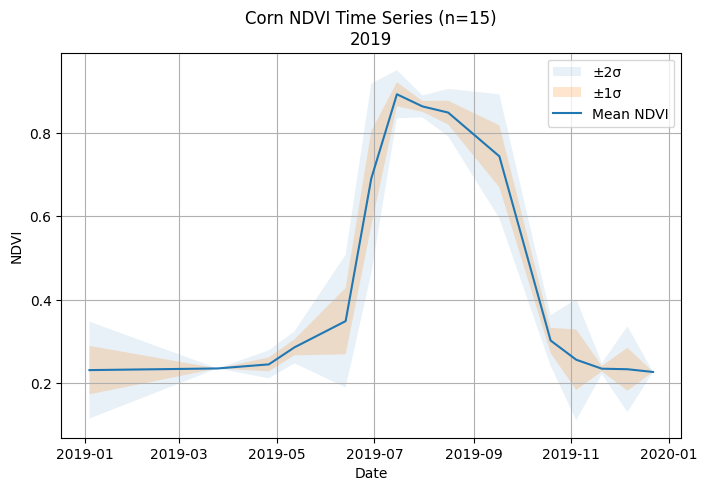

Aggregated NDVI data for Soybeans : [{'date': '2019-01-04', 'mean_ndvi': 0.2392589597039844, 'std_dev': 0.011045324034965463, 'count': 6}, {'date': '2019-04-26', 'mean_ndvi': 0.23404426113729335, 'std_dev': 0.01276484114276686, 'count': 8}, {'date': '2019-05-12', 'mean_ndvi': 0.2504219113316393, 'std_dev': 0.020084520729263013, 'count': 5}, {'date': '2019-06-13', 'mean_ndvi': 0.2676134978168846, 'std_dev': 0.02221156206130376, 'count': 8}, {'date': '2019-06-29', 'mean_ndvi': 0.40214107743750965, 'std_dev': 0.07048471799248449, 'count': 8}, {'date': '2019-07-15', 'mean_ndvi': 0.648669479786703, 'std_dev': 0.0822766093688012, 'count': 3}, {'date': '2019-07-22', 'mean_ndvi': 0.5840416193881265, 'std_dev': 0.0, 'count': 1}, {'date': '2019-07-31', 'mean_ndvi': 0.7886631302177501, 'std_dev': 0.08521311021839185, 'count': 4}, {'date': '2019-08-07', 'mean_ndvi': 0.7601771059716501, 'std_dev': 0.0, 'count': 1}, {'date': '2019-08-16', 'mean_ndvi': 0.8637790410416573, 'std_dev': 0.034802241453834

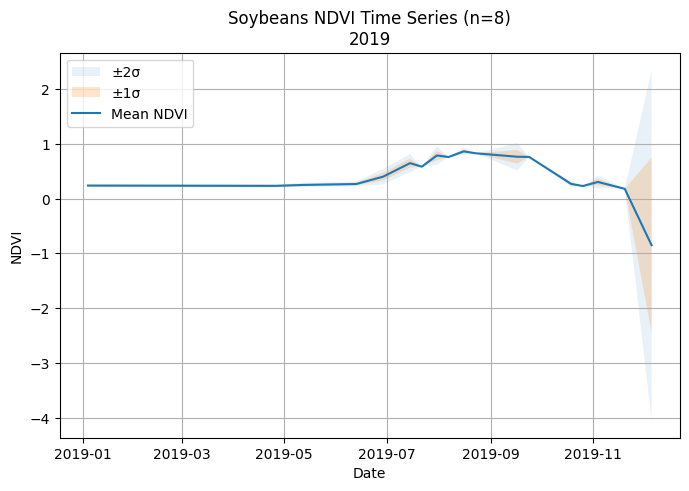

Aggregated NDVI data for Grass/Pasture : [{'date': '2019-01-04', 'mean_ndvi': 0.4130486011230021, 'std_dev': 0.0, 'count': 1}, {'date': '2019-04-26', 'mean_ndvi': 0.41634064234373586, 'std_dev': 0.0, 'count': 1}, {'date': '2019-06-13', 'mean_ndvi': 0.6710742170636341, 'std_dev': 0.0, 'count': 1}, {'date': '2019-06-29', 'mean_ndvi': 0.7570229400890937, 'std_dev': 0.0, 'count': 1}, {'date': '2019-08-16', 'mean_ndvi': 0.7176033214506277, 'std_dev': 0.0, 'count': 1}, {'date': '2019-09-17', 'mean_ndvi': 0.6297792412942165, 'std_dev': 0.0, 'count': 1}, {'date': '2019-10-19', 'mean_ndvi': 0.5100472951388076, 'std_dev': 0.0, 'count': 1}, {'date': '2019-11-04', 'mean_ndvi': 0.2618171455475845, 'std_dev': 0.0, 'count': 1}, {'date': '2019-11-20', 'mean_ndvi': 0.33362210430740774, 'std_dev': 0.0, 'count': 1}, {'date': '2019-12-06', 'mean_ndvi': 0.34598874151932857, 'std_dev': 0.0, 'count': 1}]


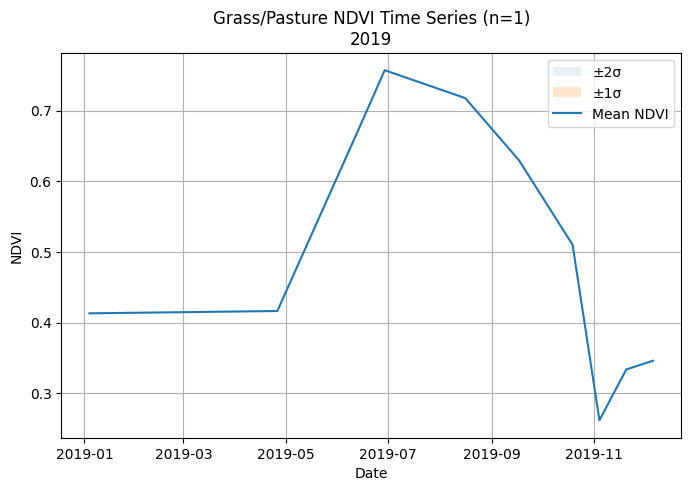

Aggregated NDVI data for Developed/Open Space : [{'date': '2019-01-04', 'mean_ndvi': 0.252160112854876, 'std_dev': 0.0, 'count': 1}, {'date': '2019-04-26', 'mean_ndvi': 0.24579854181092425, 'std_dev': 0.0, 'count': 1}, {'date': '2019-05-12', 'mean_ndvi': 0.2993197278911564, 'std_dev': 0.0, 'count': 1}, {'date': '2019-06-04', 'mean_ndvi': 0.270239506758359, 'std_dev': 0.0, 'count': 1}, {'date': '2019-06-13', 'mean_ndvi': 0.40764854287046015, 'std_dev': 0.0, 'count': 1}, {'date': '2019-06-29', 'mean_ndvi': 0.818212926130288, 'std_dev': 0.0, 'count': 1}, {'date': '2019-07-06', 'mean_ndvi': 0.799709502331626, 'std_dev': 0.0, 'count': 1}, {'date': '2019-07-15', 'mean_ndvi': 0.8761426679780473, 'std_dev': 0.0, 'count': 1}, {'date': '2019-07-22', 'mean_ndvi': 0.9099566521538015, 'std_dev': 0.0, 'count': 1}, {'date': '2019-08-07', 'mean_ndvi': 0.7999866018747069, 'std_dev': 0.0, 'count': 1}, {'date': '2019-08-16', 'mean_ndvi': 0.8341088539048949, 'std_dev': 0.0, 'count': 1}, {'date': '2019-08-

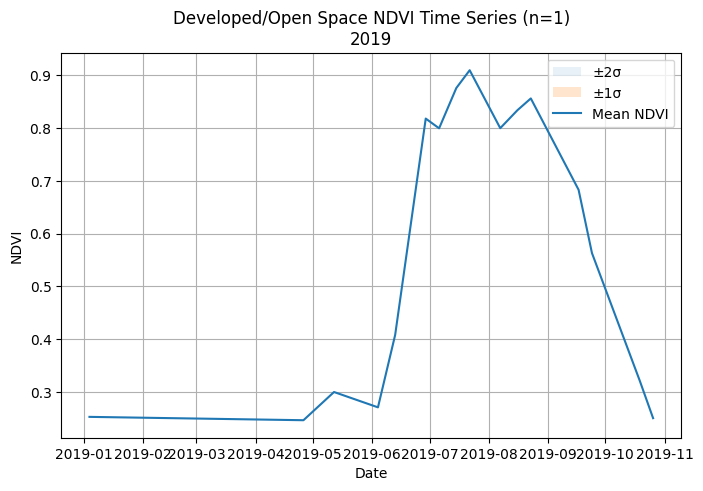

In [ ]:
# -----------------------------------------------------------------------------
# Define the county geometry for the largest county in Iowa.
# Here we use Kossuth County as an example.
iowa_counties = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', '19'))
largest_county = iowa_counties.filter(ee.Filter.eq('NAME', 'Kossuth')).first()
county_geometry = largest_county.geometry()

# Clip the CDL image to the county geometry and select the 'cropland' band.
cdl_county = ee.Image('USDA/NASS/CDL/2019').select('cropland').clip(county_geometry)

# -----------------------------------------------------------------------------
# Assume the helper functions create_grid, sample_crop_locations, mask_landsat_clouds_sr,
# add_ndvi, get_landsat_ndvi_collection, extract_ndvi_time_series, aggregate_ndvi_by_date,
# and plot_ndvi_time_series are already defined.

# For clarity, here is a simplified version of sample_crop_locations:
def sample_crop_locations(cdl_image, crop_code, crop_name, region_geom, num_points=250, method='random', grid_size=50000):
    """
    Samples pixel locations for a given crop code using different sampling methods.
    """
    # Mask the image for the given crop.
    masked_crop = cdl_image.updateMask(cdl_image.eq(crop_code))

    if method == 'random':
        sample_fc = masked_crop.sample(
            region=region_geom,
            scale=30,
            numPixels=num_points,
            geometries=True,
            seed=42
        )
    elif method == 'stratified':
        grid = create_grid(region_geom, grid_size)
        grid_count = ee.Number(grid.size())
        points_per_cell = ee.Number(num_points).divide(grid_count).round().max(1)
        def sample_in_cell(cell):
            cell_geom = cell.geometry()
            cell_sample = masked_crop.sample(
                region=cell_geom,
                scale=30,
                numPixels=points_per_cell,
                geometries=True,
                seed=42
            )
            return cell_sample
        sample_fc = grid.map(sample_in_cell).flatten()
    elif method == 'systematic':
        grid = create_grid(region_geom, grid_size)
        centroids = grid.map(lambda f: ee.Feature(f.geometry().centroid()))
        def point_in_crop(pt):
            val = masked_crop.reduceRegion(
                reducer=ee.Reducer.first(),
                geometry=pt.geometry(),
                scale=30
            ).get('cropland')
            return ee.Algorithms.IsEqual(val, val)
        systematic_points = centroids.filter(point_in_crop)
        sample_fc = systematic_points.limit(num_points, 'systematic')
    elif method in ['cluster', 'adaptive']:
        print("Warning: {} sampling not fully implemented; falling back to random sampling.".format(method))
        sample_fc = masked_crop.sample(
            region=region_geom,
            scale=30,
            numPixels=num_points,
            geometries=True,
            seed=42
        )
    else:
        raise ValueError("Unknown sampling method: {}".format(method))

    sample_fc = sample_fc.map(lambda f: f.set({"crop_code": crop_code, "crop_name": crop_name}))
    return sample_fc

# -----------------------------------------------------------------------------
# Create NDVI collection for 2019 using the county geometry.
ndvi_2019_collection = get_landsat_ndvi_collection(
    start_date='2019-01-01',
    end_date='2019-12-31',
    region=county_geometry  # Filter by the county geometry
)

# -----------------------------------------------------------------------------
# Sample points for the top 5 crops over the county.
test_samples_small = ee.FeatureCollection([])
for crop_code, crop_name in top_5_crops.items():
    fc = sample_crop_locations(
        cdl_image=cdl_county,  # Use the county-clipped CDL image
        crop_code=crop_code,
        crop_name=crop_name,
        region_geom=county_geometry,
        num_points=25,
        method='random'
    )
    test_samples_small = test_samples_small.merge(fc)

# Check the total sample points
print("Total sample points:", test_samples_small.size().getInfo())

# -----------------------------------------------------------------------------
# Extract NDVI time series from Landsat for the sampled points.
ts_small = extract_ndvi_time_series(ndvi_2019_collection, test_samples_small)

# Get the unique crop names from the sample points.
unique_crops_small = test_samples_small.aggregate_array('crop_name').distinct().getInfo()
print("Unique crops in samples:", unique_crops_small)

# -----------------------------------------------------------------------------
# For each unique crop, aggregate and plot the NDVI time series.
for c_name in unique_crops_small:
    # Filter NDVI time series for this crop.
    c_timeseries = ts_small.filter(ee.Filter.equals('crop_name', c_name))
    # Aggregate NDVI values by date.
    c_data = aggregate_ndvi_by_date(c_timeseries)
    print("Aggregated NDVI data for", c_name, ":", c_data)
    # Count the number of sample points for the crop.
    c_count = test_samples_small.filter(ee.Filter.equals('crop_name', c_name)).size().getInfo()
    # Plot the NDVI time series.
    plot_ndvi_time_series(c_data, crop_name=c_name, sample_count=c_count)

### Task 2.3: Additional Analysis (optional but recommended)

Perform any additional analysis on the crops that you find interesting or useful for modeling. This is an open-ended exploration task to dive deeper into the data. Document your methodology and insights gained from any additional analysis. Visualizations and quantitative metrics are highly encouraged. This is your opportunity to freely explore the data and extract patterns that could help with crop modeling in Task 3. Be creative and have fun with the analysis!

*Any additional analysis that provides unique insights or utility for crop modeling may receive extra credit.* The depth and uniqueness of the exploration will determine the amount of extra credit awarded.

Some examples of analysis that could warrant extra credit:
- Extracting crop rotational patterns across multiple years
- Quantifying optimal temporal windows for distinguishing between crops (e.g. dormancy, emergence, harvest)
- Analyzing the utility of additional indices on top of NDVI
- Incorporating time series from sensors across the Landsat mission (e.g. L5/L7/L8/L9)

## Task 3: Crop Identification Modeling

Goal: Develop and validate a crop classification model using satellite imagery as input.

Overview:

1. Use the sampling script from Task 2 to generate training data for developing a classification model.
2. The model should predict the 5 major crops identified in Task 1, plus a 6th "other" class.
3. The input features should include data (raw and/or derived) from Landsat surface reflectance imagery.
5. Validate model performance by calculating precision, recall, F1 score metrics on a held-out test set.
6. Apply the model to full counties in Iowa and Illinois to create crop classification maps.
7. Visually compare the model output maps to the Cropland Data Layer for analysis.

### Task 3.1: Model Development

Develop a classification model to predict crop type using satellite imagery and temporal vegetation data as input features. The model should be trained on the sampled points from Task 2 and output predictions for the 5 major crops plus a "other" class.

Key Requirements:

- Use sampled crop points (or sampling script) from Task 2 as training data.
- You may want to include more samples for the model than what was created in Task 2.
- Input features must include, but are not limited to, Landsat surface reflectance imagery from the growing season.
- Incorporate temporal vegetation indices like NDVI time series.
- Output predictions for the 5 major crops identified in Task 1 plus an "other" class. This "other" class could be expanded into multiple classes if deemed useful.
- Document modeling methodology including:
  - Model type, input features, training approach
  - Any data preprocessing/augmentation
  - Tools and libraries used
  - Modeling can be fully in GEE or combine external tools like Scikit-learn, Tensorflow, etc.

Remember that ideally, we are attempting to build a model that does NOT require data across the entire year. Put another way, the less data our model needs about the growing season to make a good prediction about the crop type, the better!

If this proves challenging, start by using an entire year's worth of data for your model (like CDL). Achieving good performance with your classifier with a full year's worth of data will earn you full credit, and extra credit will be given to in-season prediction.

### Task 3.2: Model Testing

Validate the performance of the developed crop classification model using accuracy metrics calculated on a held-out test set. This test set can be created with the same sampling strategy from before, but should be created indepdently of the training and validation data (e.g. not be seen by the model at all before testing).

Key Requirements:

- Reserve 10-20% of the training data to hold out for testing.
- Calculate precision, recall and F1 score metrics on the test set.
- Generate a confusion matrix showing per-class accuracies and errors.
- Analyze the results - where does the model perform well or poorly?
- The validation script must enable testing on new unseen data.

Interpret what the results imply about the real-world viability of the model. It's okay if you don't think your model is anywhere nearly as good as CDL is. Identify areas for improvement and potential next steps to further improve performance. Finally, document insights gained from the validation process and analysis of the results.

### Task 3.3: Model Deployment

We're at the end, now it's time to see how our model does over an entire county! Apply the developed crop classification model to full counties to create prediction maps and visually compare against ground truth data.

Key Requirements:

- Script should take any county as an input and produce an output classification.
- Specifically generate output classification results for two counties: (1) Crawford County, Iowa (2) Grant County, Wisconsin. (NOTE we did not train at all in Wisconsin!)
- Run the model over all the pixels of each county.
- Output crop classification maps with predictions at 30 meter resolution.
- Visually compare the model outputs to the Cropland Data Layer (CDL).
- Document any data exports or external processing required.

If your model was built entirely in GEE (recommended), deployment should be straightforward. If your model however was built outside of GEE and you had to export lots of data to run your mode, you may need to ingest results back into GEE (if needed) for visualization and comparison.

Analyze similarities and differences between your model output and the CDL. Do they line up at all? Is your approach viable for real-world deployment? How do the results differ when looked at a much larger geographic scale compared to the test set?

## Tips
- Start small and iterate! Begin by testing workflows on small counties before expanding to the full two states. This will help identify any issues early.
- Leverage the vast data in GEE! The Cropland Data Layer and Landsat imagery on GEE provide a rich dataset. But feel free to incorporate any other relevant data sources available.
- Plan exporting data from GEE! For large regional analysis, you may need to batch export preprocessed data to your local environment for modeling.
- Store off computationally heavy intermediate results! you may want to store intermediate FeatureCollections and Images as GEE assets such that you do not have to dynamically re-create them every time.
- Documentation is key! Thoroughly document your methodology, thought process, experiments, and results. This transparency is important for full credit.
- Visualizations tell a story! Use insightful visuals like time series plots and comparison maps to showcase your findings.
- There are many valid approaches! This assignment is open-ended by design. There are many "correct" ways to analyze the data and build models.
- Ask questions early! Please reach out if you need any guidance or get stuck. I'm happy to provide clarification and nudges in the right direction.